## Bounding box augmentation for object detection ##

In [1]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2

import albumentations as alb

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the data
dataset_dir = os.path.join(data_dir, 'dentex')

# After extraction from the .tar.gz archive, the images should be on the local fs (see the first notebook)
xrays_dir = os.path.join(dataset_dir, 'cropped')

# Let's make sure that we have the expected number of images available
expected_images = 634
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print('Make sure to run the first notebook which downloads the data.')
print(f'Found {len(file_list)} images in {xrays_dir}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

data_dir: /app/data
Make sure to run the first notebook which downloads the data.
Found 634 images in /app/data/dentex/cropped.


## Load the annotations ##

In [3]:
parquet_file_name = 'train_quadrant_enumeration_cropped.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head())

,bbox,segmentation,height,width,file_name,quadrant,pos,fdi,ada
0,"[778, 102, 103, 376]","[[869, 478, 881, 102, 790, 113, 778, 469]]",847,1770,train_0_cropped.png,1,1,11,8
1,"[705, 107, 85, 377]","[[778, 484, 790, 110, 719, 107, 716, 299, 731,...",847,1770,train_0_cropped.png,1,2,12,7
2,"[643, 69, 85, 368]","[[699, 437, 728, 357, 719, 72, 646, 69, 643, 4...",847,1770,train_0_cropped.png,1,3,13,6
3,"[569, 31, 115, 403]","[[634, 434, 684, 378, 655, 31, 575, 40, 569, 3...",847,1770,train_0_cropped.png,1,4,14,5
4,"[481, 10, 100, 406]","[[549, 416, 581, 378, 578, 10, 493, 31, 490, 2...",847,1770,train_0_cropped.png,1,5,15,4


### Bounding box format ###

In [63]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

Bounding boxes mark object locations. Albumentations needs to know the format of your bounding box coordinates. It supports four common formats:

- pascal_voc: [x_min, y_min, x_max, y_max] in absolute pixel coordinates. (x_min, y_min) is the top-left corner, and (x_max, y_max) is the bottom-right corner.

- albumentations: Similar to pascal_voc, but uses normalized coordinates: [normalized_x_min, normalized_y_min, normalized_x_max, normalized_y_max]. These are calculated as x_pixel / image_width and y_pixel / image_height.

- coco: [x_min, y_min, bbox_width, bbox_height] in absolute pixel coordinates. (x_min, y_min) is the top-left corner.

- yolo: [normalized_x_center, normalized_y_center, normalized_bbox_width, normalized_bbox_height]. These are normalized coordinates.

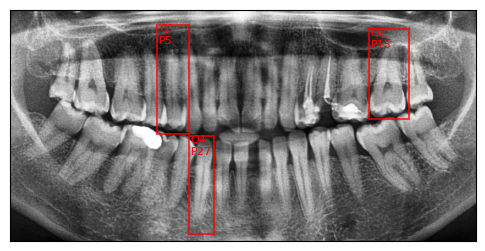

In [190]:
# Example of a bounding box in coco format
# Pick an image
image_idx = 17
file_name = df['file_name'].unique()[image_idx]
df_file = df.loc[df['file_name'] == file_name]
file = os.path.join(xrays_dir, file_name)

# Load the image
im = ImageData().load_image(file)
# Do some contrast enhancement to make this look nicer
im = ImageData().hist_eq(im, color_space='GRAY')

# Pick three random bounding boxes and labels
seed = 111
n_boxes = 3
df_sample = df_file.sample(n=n_boxes, random_state=seed)
box_list = [list(box) for box in df_sample['bbox'].tolist()]
position_list = df_sample['ada'].tolist()
quadrant_list = df_sample['quadrant'].tolist()
label_list = [f'Q{q}\nP{p}' for q, p in zip(quadrant_list, position_list)] 

# Plot the image with the bounding boxes
fig, ax = plt.subplots(figsize = (7, 3))
ax = plot_boxes(image=im, box_list=box_list, label_list=label_list, ax=ax, color='r')
plt.show()

### Augmenting bounding boxes ###

In [191]:
# Transformations
transformations = [alb.HorizontalFlip(p=1.0)]

# Bounding box parameters
label_fields = ['quadrants', 'positions']
bbox_parameters = {'format': 'coco',
                   'label_fields': label_fields}
bbox_params = alb.BboxParams(**bbox_parameters)

# Create the transformation
transform = alb.Compose(transformations, bbox_params=bbox_params)

# Access the parameters from the processor object
box_processor = transform.processors.get('bboxes')
label_fields = box_processor.params.label_fields if box_processor else []
print(label_fields)

['quadrants', 'positions']


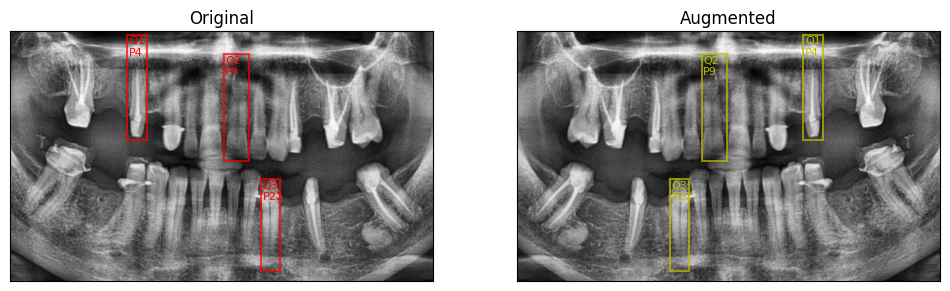

In [137]:
# Prepare the data pipeline
bboxes = np.array(box_list)
label_args = dict(zip(label_fields, [quadrant_list, position_list]))

# Run the data augmentation
augmented = transform(image=im, bboxes=bboxes, **label_args) 

# Extract the augmented data
aug_image = augmented['image']
aug_boxes = augmented['bboxes']
aug_labels = {field: np.array(augmented.get(field)).astype(int) for field in label_fields}
aug_label_list = [f'Q{q}\nP{p}' for q, p in zip(aug_labels['quadrants'], aug_labels['positions'])] 

# Plot the original and augmented images side-by-side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0] = plot_boxes(image=im, box_list=box_list, ax=ax[0], label_list=label_list, color='r')
ax[1] = plot_boxes(image=aug_image, box_list=aug_boxes, ax=ax[1], label_list=aug_label_list, color='y')
ax[0].set_title('Original')
ax[1].set_title('Augmented')
plt.show()

### Cropping strategies for object detection: random cropping ###
We want to apply random crops to create smaller images with teeth.

Albumentations provides specialized cropping transforms that are safer for bounding boxes:

A.AtLeastOneBboxRandomCrop: This transform crops a random area but guarantees that at least one bounding box from the original image is present within the crop. It's useful when you want diverse crops but are willing to lose some boxes, perhaps focusing training on individual objects or when images contain many redundant boxes.

A.BBoxSafeRandomCrop: This transform also crops a random area but guarantees that all bounding boxes are preserved within the crop (potentially by cropping a smaller area if needed). This is suitable when losing any bounding box is problematic (e.g., detecting all instances is critical, or you have rare objects).

A.RandomSizedBBoxSafeCrop: This is a very common and powerful transform. It crops a random portion of the image (with varying size and aspect ratio, similar to RandomResizedCrop in classification) while ensuring all bounding boxes remain within the cropped area. It then resizes this potentially non-square crop to your target height and width. This provides scale and aspect ratio augmentation while preserving all objects.

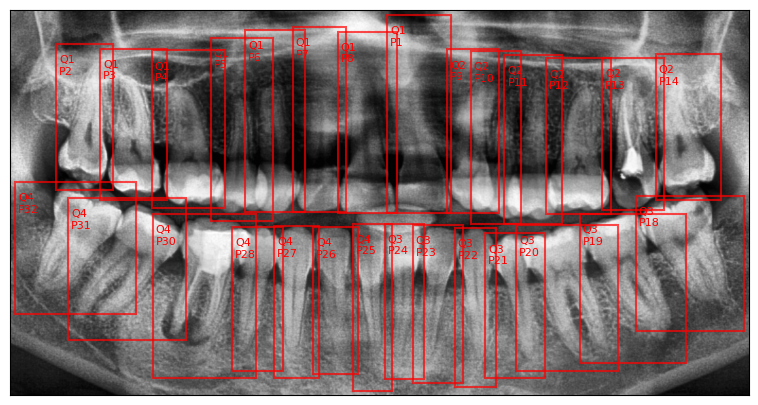

In [205]:
# Pick an image
image_idx = 19
file_name = df['file_name'].unique()[image_idx]
df_file = df.loc[df['file_name'] == file_name]
file = os.path.join(xrays_dir, file_name)

# Load the image
im = ImageData().load_image(file)
im = ImageData().hist_eq(im, color_space='GRAY')

# Get the bounding boxes with the labels
box_list = [list(box) for box in df_file['bbox'].tolist()]
position_list = df_file['ada'].tolist()
quadrant_list = df_file['quadrant'].tolist()
label_list = [f'Q{q}\nP{p}' for q, p in zip(quadrant_list, position_list)] 

# Original image with bounding boxes
fig, ax = plt.subplots(figsize=(10, 5))
ax = plot_boxes(image=im, box_list=box_list, label_list=label_list, ax=ax, color='r')
plt.show()

To create a random crop that is only vertically centered in Albumentations, you can use the A.Crop transform and define a custom range for the horizontal crop coordinates. By setting the vertical coordinates (y_min and y_max) to fixed values, you ensure the vertical center is always cropped, while the horizontal coordinates (x_min and x_max) are randomized. 

In [ ]:
# Can we create a function that carries out the transformataion and then try different transforms?


In [208]:
# Crop transformations

# Center crop
transformation_list = [alb.CenterCrop(height=300, width=300, p=1.0)]


Height: 300 Width: 300


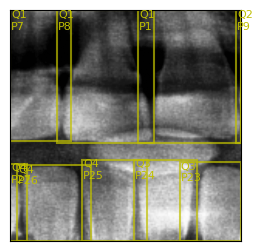

In [207]:
# The bounding box format
label_fields = ['quadrants', 'positions']
bbox_parameters = {'format': 'coco',
                   'label_fields': label_fields,
                   'clip': True}

bbox_params = alb.BboxParams(**bbox_parameters)

# The actual albumentations transform
transform = alb.Compose(transformation_list, bbox_params=bbox_params)

# Prepare the bounding boxes and the labels
bboxes = np.array(box_list)
label_args = dict(zip(label_fields, [quadrant_list, position_list]))

# Run the data augmentation
augmented = transform(image=im, bboxes=bboxes, **label_args) 

# Retrieve the augmented data
aug_im = augmented['image']
aug_boxes = augmented['bboxes']
aug_labels = {field: np.array(augmented.get(field)).astype(int) for field in label_fields}
aug_label_list = [f'Q{q}\nP{p}' for q, p in zip(aug_labels['quadrants'], aug_labels['positions'])] 

# Plot the augmented data
print(f'Height: {aug_im.shape[0]} Width: {aug_im.shape[1]}')
fig, ax = plt.subplots(figsize=(6, 3))
ax = plot_boxes(image=aug_im, box_list=aug_boxes, label_list=aug_label_list, ax=ax, color='y')